# Neural Networks Sprint Challenge

## 1) Define the following terms:

- Neuron
- Input Layer
- Hidden Layer
- Output Layer
- Activation
- Backpropagation

*Neurons:* "Nodes" that receive inputs and pass on their signal to the next layer of nodes if a certain threshold is reached.

*Input Layer:* What receives input from our dataset. Sometimes it is called the visible layer because it's the only part that is exposed to our data and that our data interacts with directly. 

*Hidden Layer:* Layers after the input layer are called Hidden Layers. This is because they cannot be accessed except through the input layer. They're inside of the network and they perform their functions, but we don't directly interact with them.

*Output Layer:* The final layer is called the Output Layer. The purpose of the output layer is to output a vector of values that is in a format that is suitable for the type of problem that we're trying to address.

*Activation:* In Artificial Neural Networks activation functions decide how much signal to pass onto the next layer. This is why they are sometimes referred to as transfer functions because they determine how much signal is transferred to the next layer.

*Backpropagation:* Backpropagation is short for "Backwards Propagation of errors" and refers to a specific algorithm for how weights in a neural network are updated in reverse order at the end of each training epoch.

## 2) Create a perceptron class that can model the behavior of an AND gate. You can use the following table as your training data:

| x1 | x2 | x3 | y |
|----|----|----|---|
| 1  | 1  | 1  | 1 |
| 1  | 0  | 1  | 0 |
| 0  | 1  | 1  | 0 |
| 0  | 0  | 1  | 0 |

In [1]:
import numpy as np
inputs = np.array([[1,1,1], 
                  [1,0,1], 
                  [0,1,1], 
                  [0,0,1]])

correct_outputs = [[1], 
                    [0], 
                    [0], 
                    [0]]

weights = 2 * np.random.random((3,1)) - 1
weights

array([[0.74679654],
       [0.74026002],
       [0.45129552]])

In [2]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
  return sigmoid(x) * (1 - sigmoid(x))

In [3]:
for iteration in range(10000):
  
    # Weighted sum of inputs and weights
    weighted_sum = np.dot(inputs, weights)

    # Activate with sigmoid function
    activated_output = sigmoid(weighted_sum)

    # Calculate Error
    error = correct_outputs - activated_output

    # Calculate weight adjustments with sigmoid_derivative
    adjustments = error * sigmoid_derivative(activated_output)

    # Update weights
    weights += np.dot(inputs.T, adjustments)
    
  
print('optimized weights after training: ')
print(weights)

print("Output After Training:")
print(activated_output)

optimized weights after training: 
[[ 11.8403207 ]
 [ 11.8403207 ]
 [-18.04879029]]
Output After Training:
[[9.96430489e-01]
 [2.00847479e-03]
 [2.00847479e-03]
 [1.45091111e-08]]


## 3) Implement a Neural Network Multilayer Perceptron class that uses backpropagation to update the network's weights. 
- Your network must have one hidden layer. 
- You do not have to update weights via gradient descent. You can use something like the derivative of the sigmoid function to update weights.
- Train your model on the Heart Disease dataset from UCI:

[Github Dataset](https://github.com/ryanleeallred/datasets/blob/master/heart.csv)

[Raw File on Github](https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv)


In [4]:
import pandas as pd

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/heart.csv")
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [87]:
from sklearn.preprocessing import StandardScaler

X = df.drop(columns=['target'])
y = df['target']

# Scale inputs
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = X.reshape(-1,13)
y = np.array(y).reshape(-1,1)

print(X)
print(y)

[[ 0.9521966   0.68100522  1.97312292 ... -2.27457861 -0.71442887
  -2.14887271]
 [-1.91531289  0.68100522  1.00257707 ... -2.27457861 -0.71442887
  -0.51292188]
 [-1.47415758 -1.46841752  0.03203122 ...  0.97635214 -0.71442887
  -0.51292188]
 ...
 [ 1.50364073  0.68100522 -0.93851463 ... -0.64911323  1.24459328
   1.12302895]
 [ 0.29046364  0.68100522 -0.93851463 ... -0.64911323  0.26508221
   1.12302895]
 [ 0.29046364 -1.46841752  0.03203122 ... -0.64911323  0.26508221
  -0.51292188]]
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1

In [59]:
class Neural_Network(object):
  def __init__(self):
    self.inputs = 13
    self.hiddenNodes = 7
    self.outputNodes = 1
    
    # Initlize Weights
    self.L1_weights = np.random.randn(self.inputs, self.hiddenNodes) # (13x7)
    self.L2_weights = np.random.randn(self.hiddenNodes, self.outputNodes) # (7x1)

In [60]:
NN = Neural_Network()

print("Layer 1 weights: \n", NN.L1_weights)
print("Layer 2 weights: \n", NN.L2_weights)

Layer 1 weights: 
 [[-0.2403254  -0.37482081  0.71095997  0.44426331 -0.36096617  1.1593298
  -1.08106333]
 [ 0.61593561  0.59310126 -0.30954644  0.32613302 -1.25111358  0.92402702
  -0.18490214]
 [-0.52272302  1.04900923 -0.70434369 -1.4084613  -1.55662917  0.60600995
  -1.28042935]
 [ 1.75479418 -2.08192941  1.69645637  0.21101747 -0.09671311 -0.54491909
   0.39913611]
 [-0.0376347   1.10330188  0.11422765  0.15030176 -0.36361221 -0.05694562
   0.30780177]
 [-1.71016839 -1.34818542  0.74326409  0.17086544 -0.18398334  0.01843393
   0.34758171]
 [-0.53975968 -0.77830473  0.19584526 -0.97837278  0.40825276 -1.7025836
   1.02915564]
 [ 0.47259748  0.25602973  0.98269098  1.66547444  1.01437007 -1.84087423
  -1.27957697]
 [-0.62481858  0.02609105  0.51765902 -0.72574381  0.18676676 -0.75538293
  -0.6115178 ]
 [-1.4066611  -0.92323325 -1.35168461 -0.97587325  1.0536418  -0.94939889
   2.63238206]
 [ 0.4933179   0.18483612 -0.85835778  0.70030988 -0.57563783  0.12200981
   2.56008454]
 [-0

In [61]:
class Neural_Network(object):
  def __init__(self):
    self.inputs = 13
    self.hiddenNodes = 7
    self.outputNodes = 1

    # Initlize Weights
    self.L1_weights = np.random.randn(self.inputs, self.hiddenNodes) # (13x7)
    self.L2_weights = np.random.randn(self.hiddenNodes, self.outputNodes) # (7x1)

  def feed_forward(self, X):
    # Weighted sum between inputs and hidden layer
    self.hidden_sum = np.dot(X, self.L1_weights)
    # Activations of weighted sum
    self.activated_hidden = self.sigmoid(self.hidden_sum)
    # Weighted sum between hidden and output
    self.output_sum = np.dot(self.activated_hidden, self.L2_weights)
    # final activation of output
    self.activated_output = self.sigmoid(self.output_sum)
    return self.activated_output
    
  def sigmoid(self, s):
    return 1/(1+np.exp(-s))

In [62]:
NN = Neural_Network()
output = NN.feed_forward(X[0])
print("output: ", output)

output:  [0.86790084]


In [63]:
print(y[0]-output)

[0.13209916]


In [64]:
# Look at how a single observation is processed
print("Inputs: \n", X[0])
print("Initial Weights \n", NN.L1_weights)
print("Weighted Sum 1 \n", NN.hidden_sum)
print("Activations from first layer: \n", NN.activated_hidden)
print("Second Layer Weights \n", NN.L2_weights)
print("Weighted Sum 2 \n", NN.output_sum)
print("Predictions \n", output)
print("Correct Output: \n", y[0])
print("Error \n", y[0]-output)

Inputs: 
 [ 0.9521966   0.68100522  1.97312292  0.76395577 -0.25633371  2.394438
 -1.00583187  0.01544279 -0.69663055  1.08733806 -2.27457861 -0.71442887
 -2.14887271]
Initial Weights 
 [[ 0.55979045  1.08078073  0.83392215  0.45918008 -0.07016571 -1.66096093
   0.42961822]
 [ 0.20768769  0.27157884 -1.27674858 -1.08105654  1.05315285 -0.03955515
   0.6815007 ]
 [ 0.02831838  0.02975614  0.93828381 -0.51604473  0.09612078 -0.46227529
  -0.43449623]
 [-0.30917212  0.22213377 -0.47874862  1.25575613 -0.8946073  -0.18687164
  -0.43973106]
 [ 1.44697788  0.19655478  1.03184454 -1.48556037  0.26705027  0.8896308
   0.08228399]
 [ 1.06548038 -0.51728845  1.40934744  2.29889812 -0.36283856 -0.44550252
   1.45338448]
 [ 1.57957215 -0.52286003 -0.42018682 -0.28178461 -1.34445051 -0.91865195
  -1.00414077]
 [-0.76779757 -0.03468489  0.23421473  1.55050049 -0.99835404  0.9843224
  -0.21398884]
 [-0.04946371  0.67481949 -1.12272202  0.38240975  0.16645221  0.49245126
   0.28916864]
 [ 2.45530014 -

In [94]:
class Neural_Network(object):
  def __init__(self):
    self.inputs = 13
    self.hiddenNodes = 7
    self.outputNodes = 1

    # Initialize Weights:
    self.L1_weights = np.random.randn(self.inputs, self.hiddenNodes) 
    self.L2_weights = np.random.randn(self.hiddenNodes, self.outputNodes) 

  def feed_forward(self, X):
    
    # Weighted sum between inputs and hidden layer:
    self.hidden_sum = np.dot(X, self.L1_weights)
    
    # Activations of weighted sum:
    self.activated_hidden = self.sigmoid(self.hidden_sum)
    
    # Weighted sum between hidden and output:
    self.output_sum = np.dot(self.activated_hidden, self.L2_weights)
    
    # final activation of output:
    self.activated_output = self.sigmoid(self.output_sum)
    
    return self.activated_output
    
  def sigmoid(self, s):
    return 1/(1+np.exp(-s))
  
  #sigmoid derivative  
  def sigmoidPrime(self, s):
    return s * (1 - s)
  
 #dCost/dWeights =    
    
  def backward(self, X, y, output):
    # backward propgate through the network
    
    # error in output:
    self.output_error = y - output 
    
    # applying derivative of sigmoid to error:
    self.output_delta = self.output_error * self.sigmoidPrime(output) 
    
    # z2 error: how much our hidden layer weights contributed to output error:
    self.z2_error = self.output_delta.dot(self.L2_weights.T)
    
    # applying derivative of sigmoid to z2 error:
    self.z2_delta = self.z2_error*self.sigmoidPrime(self.activated_hidden) 
    
    # adjusting first set (input --> hidden) weights:
    self.L1_weights += X.T.dot(self.z2_delta) 
    
    # adjusting second set (hidden --> output) weights:
    self.L2_weights += self.activated_hidden.T.dot(self.output_delta) 
    
  def train (self, X, y):
    output = self.feed_forward(X)
    self.backward(X, y, output)
    
NN = Neural_Network()
for i in range(1000): # trains the NN 1,000 times
  if i+1 in [1,2,3,4,5] or (i+1) % 50 == 0:
    print('+---------- EPOCH', i+1, '-----------+')
#     print("Input: \n", X) 
#     print("Actual Output: \n", y)  
#     print("Predicted Output: \n" + str(NN.feed_forward(X))) 
    print("Loss: \n" + str(np.mean(np.square(y - NN.feed_forward(X))))) # mean sum squared loss
    print("\n")
  NN.train(X, y)

+---------- EPOCH 1 -----------+
Loss: 
0.30155643516305275


+---------- EPOCH 2 -----------+
Loss: 
0.45294491486297417


+---------- EPOCH 3 -----------+
Loss: 
0.4439870176013505


+---------- EPOCH 4 -----------+
Loss: 
0.30352132579284413


+---------- EPOCH 5 -----------+
Loss: 
0.15572076239042495


+---------- EPOCH 50 -----------+
Loss: 
0.06519320738345506


+---------- EPOCH 100 -----------+
Loss: 
0.05491251277384708


+---------- EPOCH 150 -----------+
Loss: 
0.0386101878771964


+---------- EPOCH 200 -----------+
Loss: 
0.036410601573729086


+---------- EPOCH 250 -----------+
Loss: 
0.028862732859014112


+---------- EPOCH 300 -----------+
Loss: 
0.020778504071734694


+---------- EPOCH 350 -----------+
Loss: 
0.020258305845238106


+---------- EPOCH 400 -----------+
Loss: 
0.020135863702743482


+---------- EPOCH 450 -----------+
Loss: 
0.02007106319748182


+---------- EPOCH 500 -----------+
Loss: 
0.020026414935921492


+---------- EPOCH 550 -----------+
Loss: 
0.019

## 4) Implement a Multilayer Perceptron architecture of your choosing using the Keras library. Train your model and report its baseline accuracy. Then hyperparameter tune at least two parameters and report your model's accuracy. 

- Use the Heart Disease Dataset (binary classification)
- Use an appropriate loss function for a binary classification task
- Use an appropriate activation function on the final layer of your network. 
- Train your model using verbose output for ease of grading.
- Use GridSearchCV to hyperparameter tune your model. (for at least two hyperparameters)
- When hyperparameter tuning, show you work by adding code cells for each new experiment. 
- Report the accuracy for each combination of hyperparameters as you test them so that we can easily see which resulted in the highest accuracy.
- You must hyperparameter tune at least 5 parameters in order to get a 3 on this section.

In [107]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

np.random.seed(42)

# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1)

history = model.fit(X, y, epochs=150)

Epoch 1/150
303/303 [==============================] - 2s 5ms/step - loss: 0.6950 - acc: 0.5974
Epoch 2/150
303/303 [==============================] - 0s 44us/step - loss: 0.6634 - acc: 0.6403
Epoch 3/150
303/303 [==============================] - 0s 45us/step - loss: 0.6359 - acc: 0.6766
Epoch 4/150
303/303 [==============================] - 0s 47us/step - loss: 0.6120 - acc: 0.7096
Epoch 5/150
303/303 [==============================] - 0s 50us/step - loss: 0.5908 - acc: 0.7195
Epoch 6/150
303/303 [==============================] - 0s 54us/step - loss: 0.5719 - acc: 0.7360
Epoch 7/150
303/303 [==============================] - 0s 47us/step - loss: 0.5532 - acc: 0.7459
Epoch 8/150
303/303 [==============================] - 0s 54us/step - loss: 0.5374 - acc: 0.7624
Epoch 9/150
303/303 [==============================] - 0s 46us/step - loss: 0.5234 - acc: 0.7690
Epoch 10/150
303/303 [==============================] - 0s 54us/step - loss: 0.5105 - acc: 0.7723
Epoch 11/150
303/303 [========

303/303 [==============================] - 0s 46us/step - loss: 0.2986 - acc: 0.8779
Epoch 85/150
303/303 [==============================] - 0s 44us/step - loss: 0.2980 - acc: 0.8779
Epoch 86/150
303/303 [==============================] - 0s 51us/step - loss: 0.2970 - acc: 0.8779
Epoch 87/150
303/303 [==============================] - 0s 53us/step - loss: 0.2960 - acc: 0.8779
Epoch 88/150
303/303 [==============================] - 0s 46us/step - loss: 0.2953 - acc: 0.8779
Epoch 89/150
303/303 [==============================] - 0s 43us/step - loss: 0.2942 - acc: 0.8812
Epoch 90/150
303/303 [==============================] - 0s 48us/step - loss: 0.2935 - acc: 0.8845
Epoch 91/150
303/303 [==============================] - 0s 40us/step - loss: 0.2925 - acc: 0.8845
Epoch 92/150
303/303 [==============================] - 0s 51us/step - loss: 0.2917 - acc: 0.8845
Epoch 93/150
303/303 [==============================] - 0s 41us/step - loss: 0.2909 - acc: 0.8845
Epoch 94/150
303/303 [===========

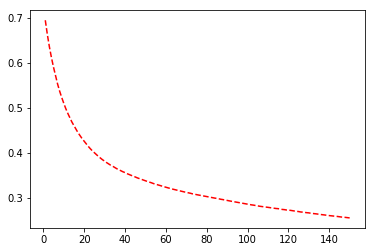

In [108]:
import matplotlib.pyplot as plt
training_loss = history.history['loss']
epoch_count = range(1, len(training_loss) + 1)

plt.plot(epoch_count, training_loss, 'r--')
plt.show();

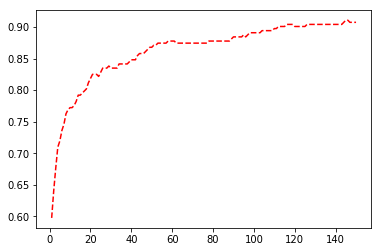

In [109]:
training_accuracy = history.history['acc']
epoch_count = range(1, len(training_accuracy) + 1)

plt.plot(epoch_count, training_accuracy, 'r--')
plt.show();

In [110]:
# Gridsearch on batch size

# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(Dense(13, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1)

# define the grid search parameters
batch_size = [20,40,60,80]
epochs = [20]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X, y)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
print()
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Epoch 1/20
202/202 [==============================] - 2s 8ms/step - loss: 0.6147 - acc: 0.6881
Epoch 2/20
202/202 [==============================] - 0s 89us/step - loss: 0.5924 - acc: 0.7129
Epoch 3/20
202/202 [==============================] - 0s 91us/step - loss: 0.5732 - acc: 0.7327
Epoch 4/20
202/202 [==============================] - 0s 88us/step - loss: 0.5538 - acc: 0.7376
Epoch 5/20
202/202 [==============================] - 0s 93us/step - loss: 0.5365 - acc: 0.7574
Epoch 6/20
202/202 [==============================] - 0s 93us/step - loss: 0.5195 - acc: 0.7772
Epoch 7/20
202/202 [==============================] - 0s 92us/step - loss: 0.5038 - acc: 0.7772
Epoch 8/20
202/202 [==============================] - 0s 93us/step - loss: 0.4892 - acc: 0.7871
Epoch 9/20
202/202 [==============================] - 0s 94us/step - loss: 0.4746 - acc: 0.7921
Epoch 10/20
202/202 [==============================] - 0s 85us/step - loss: 0.4609 - acc: 0.8069
Epoch 11/20
202/202 [===================

202/202 [==============================] - 2s 8ms/step - loss: 0.6686 - acc: 0.6040
Epoch 2/20
202/202 [==============================] - 0s 46us/step - loss: 0.6522 - acc: 0.5990
Epoch 3/20
202/202 [==============================] - 0s 51us/step - loss: 0.6382 - acc: 0.6040
Epoch 4/20
202/202 [==============================] - 0s 41us/step - loss: 0.6238 - acc: 0.6337
Epoch 5/20
202/202 [==============================] - 0s 43us/step - loss: 0.6115 - acc: 0.6535
Epoch 6/20
202/202 [==============================] - 0s 51us/step - loss: 0.5993 - acc: 0.6634
Epoch 7/20
202/202 [==============================] - 0s 48us/step - loss: 0.5886 - acc: 0.6832
Epoch 8/20
202/202 [==============================] - 0s 48us/step - loss: 0.5782 - acc: 0.6931
Epoch 9/20
202/202 [==============================] - 0s 48us/step - loss: 0.5685 - acc: 0.7129
Epoch 10/20
202/202 [==============================] - 0s 44us/step - loss: 0.5583 - acc: 0.7178
Epoch 11/20
202/202 [==============================

202/202 [==============================] - 2s 9ms/step - loss: 0.7964 - acc: 0.4307
Epoch 2/20
202/202 [==============================] - 0s 34us/step - loss: 0.7749 - acc: 0.4604
Epoch 3/20
202/202 [==============================] - 0s 35us/step - loss: 0.7522 - acc: 0.4752
Epoch 4/20
202/202 [==============================] - 0s 31us/step - loss: 0.7315 - acc: 0.5149
Epoch 5/20
202/202 [==============================] - 0s 29us/step - loss: 0.7122 - acc: 0.5495
Epoch 6/20
202/202 [==============================] - 0s 30us/step - loss: 0.6928 - acc: 0.5842
Epoch 7/20
202/202 [==============================] - 0s 30us/step - loss: 0.6740 - acc: 0.6238
Epoch 8/20
202/202 [==============================] - 0s 30us/step - loss: 0.6564 - acc: 0.6535
Epoch 9/20
202/202 [==============================] - 0s 28us/step - loss: 0.6394 - acc: 0.6782
Epoch 10/20
202/202 [==============================] - 0s 32us/step - loss: 0.6223 - acc: 0.7079
Epoch 11/20
202/202 [==============================

303/303 [==============================] - 2s 6ms/step - loss: 0.8095 - acc: 0.4125
Epoch 2/20
303/303 [==============================] - 0s 36us/step - loss: 0.7748 - acc: 0.4521
Epoch 3/20
303/303 [==============================] - 0s 35us/step - loss: 0.7420 - acc: 0.5083
Epoch 4/20
303/303 [==============================] - 0s 33us/step - loss: 0.7138 - acc: 0.5479
Epoch 5/20
303/303 [==============================] - 0s 33us/step - loss: 0.6859 - acc: 0.5842
Epoch 6/20
303/303 [==============================] - 0s 33us/step - loss: 0.6615 - acc: 0.5908
Epoch 7/20
303/303 [==============================] - 0s 32us/step - loss: 0.6394 - acc: 0.6238
Epoch 8/20
303/303 [==============================] - 0s 31us/step - loss: 0.6175 - acc: 0.6568
Epoch 9/20
303/303 [==============================] - 0s 32us/step - loss: 0.5986 - acc: 0.7030
Epoch 10/20
303/303 [==============================] - 0s 43us/step - loss: 0.5800 - acc: 0.7360
Epoch 11/20
303/303 [==============================

In [111]:
# Gridsearch on epochs

# Function to create model, required for KerasClassifier
def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=13, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1)

# define the grid search parameters
batch_size = [40]
epochs = [10,20,40,60,80,100,150]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X, y)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
print()
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Epoch 1/10
202/202 [==============================] - 2s 10ms/step - loss: 1.0945 - acc: 0.3564
Epoch 2/10
202/202 [==============================] - 0s 60us/step - loss: 1.0571 - acc: 0.3663
Epoch 3/10
202/202 [==============================] - 0s 57us/step - loss: 1.0202 - acc: 0.3713
Epoch 4/10
202/202 [==============================] - 0s 53us/step - loss: 0.9864 - acc: 0.3762
Epoch 5/10
202/202 [==============================] - 0s 57us/step - loss: 0.9547 - acc: 0.3911
Epoch 6/10
202/202 [==============================] - 0s 62us/step - loss: 0.9246 - acc: 0.4208
Epoch 7/10
202/202 [==============================] - 0s 61us/step - loss: 0.8984 - acc: 0.4653
Epoch 8/10
202/202 [==============================] - 0s 65us/step - loss: 0.8737 - acc: 0.4851
Epoch 9/10
202/202 [==============================] - 0s 60us/step - loss: 0.8483 - acc: 0.4950
Epoch 10/10
202/202 [==============================] - 0s 30us/step
Epoch 1/10
202/202 [==============================] - 2s 10ms/step -

202/202 [==============================] - 0s 53us/step - loss: 0.7057 - acc: 0.5743
Epoch 11/20
202/202 [==============================] - 0s 58us/step - loss: 0.6880 - acc: 0.5842
Epoch 12/20
202/202 [==============================] - 0s 50us/step - loss: 0.6707 - acc: 0.6139
Epoch 13/20
202/202 [==============================] - 0s 53us/step - loss: 0.6536 - acc: 0.6188
Epoch 14/20
202/202 [==============================] - 0s 56us/step - loss: 0.6363 - acc: 0.6436
Epoch 15/20
202/202 [==============================] - 0s 64us/step - loss: 0.6208 - acc: 0.6683
Epoch 16/20
202/202 [==============================] - 0s 63us/step - loss: 0.6069 - acc: 0.6782
Epoch 17/20
202/202 [==============================] - 0s 52us/step - loss: 0.5927 - acc: 0.6832
Epoch 18/20
202/202 [==============================] - 0s 62us/step - loss: 0.5786 - acc: 0.7030
Epoch 19/20
202/202 [==============================] - 0s 54us/step - loss: 0.5642 - acc: 0.7030
Epoch 20/20
202/202 [=====================

202/202 [==============================] - 0s 59us/step - loss: 0.5049 - acc: 0.7673
Epoch 33/40
202/202 [==============================] - 0s 58us/step - loss: 0.4983 - acc: 0.7723
Epoch 34/40
202/202 [==============================] - 0s 52us/step - loss: 0.4924 - acc: 0.7871
Epoch 35/40
202/202 [==============================] - 0s 64us/step - loss: 0.4863 - acc: 0.7871
Epoch 36/40
202/202 [==============================] - 0s 61us/step - loss: 0.4803 - acc: 0.7772
Epoch 37/40
202/202 [==============================] - 0s 63us/step - loss: 0.4744 - acc: 0.7822
Epoch 38/40
202/202 [==============================] - 0s 51us/step - loss: 0.4686 - acc: 0.7921
Epoch 39/40
202/202 [==============================] - 0s 60us/step - loss: 0.4632 - acc: 0.8020
Epoch 40/40
202/202 [==============================] - 0s 50us/step
Epoch 1/40
202/202 [==============================] - 2s 11ms/step - loss: 0.7862 - acc: 0.3564
Epoch 2/40
202/202 [==============================] - 0s 51us/step - los

202/202 [==============================] - 0s 51us/step - loss: 0.4645 - acc: 0.7871
Epoch 35/60
202/202 [==============================] - 0s 60us/step - loss: 0.4607 - acc: 0.7921
Epoch 36/60
202/202 [==============================] - 0s 54us/step - loss: 0.4561 - acc: 0.7921
Epoch 37/60
202/202 [==============================] - 0s 61us/step - loss: 0.4520 - acc: 0.7921
Epoch 38/60
202/202 [==============================] - 0s 60us/step - loss: 0.4481 - acc: 0.7970
Epoch 39/60
202/202 [==============================] - 0s 65us/step - loss: 0.4446 - acc: 0.7921
Epoch 40/60
202/202 [==============================] - 0s 56us/step - loss: 0.4411 - acc: 0.7921
Epoch 41/60
202/202 [==============================] - 0s 59us/step - loss: 0.4375 - acc: 0.7921
Epoch 42/60
202/202 [==============================] - 0s 62us/step - loss: 0.4343 - acc: 0.7921
Epoch 43/60
202/202 [==============================] - 0s 58us/step - loss: 0.4314 - acc: 0.7921
Epoch 44/60
202/202 [=====================

202/202 [==============================] - 0s 67us/step - loss: 0.3690 - acc: 0.8366
Epoch 58/60
202/202 [==============================] - 0s 55us/step - loss: 0.3669 - acc: 0.8317
Epoch 59/60
202/202 [==============================] - 0s 53us/step - loss: 0.3648 - acc: 0.8366
Epoch 60/60
202/202 [==============================] - 0s 41us/step
Epoch 1/60
202/202 [==============================] - 2s 11ms/step - loss: 0.8597 - acc: 0.4604
Epoch 2/60
202/202 [==============================] - 0s 59us/step - loss: 0.8270 - acc: 0.5000
Epoch 3/60
202/202 [==============================] - 0s 51us/step - loss: 0.7985 - acc: 0.5248
Epoch 4/60
202/202 [==============================] - 0s 48us/step - loss: 0.7710 - acc: 0.5644
Epoch 5/60
202/202 [==============================] - 0s 65us/step - loss: 0.7432 - acc: 0.5990
Epoch 6/60
202/202 [==============================] - 0s 51us/step - loss: 0.7184 - acc: 0.6188
Epoch 7/60
202/202 [==============================] - 0s 62us/step - loss: 0.

202/202 [==============================] - 0s 63us/step - loss: 0.5211 - acc: 0.7723
Epoch 20/80
202/202 [==============================] - 0s 61us/step - loss: 0.5155 - acc: 0.7822
Epoch 21/80
202/202 [==============================] - 0s 62us/step - loss: 0.5092 - acc: 0.7822
Epoch 22/80
202/202 [==============================] - 0s 73us/step - loss: 0.5041 - acc: 0.7970
Epoch 23/80
202/202 [==============================] - 0s 61us/step - loss: 0.4985 - acc: 0.7970
Epoch 24/80
202/202 [==============================] - 0s 68us/step - loss: 0.4930 - acc: 0.7970
Epoch 25/80
202/202 [==============================] - 0s 57us/step - loss: 0.4880 - acc: 0.7970
Epoch 26/80
202/202 [==============================] - 0s 63us/step - loss: 0.4829 - acc: 0.8020
Epoch 27/80
202/202 [==============================] - 0s 61us/step - loss: 0.4781 - acc: 0.8020
Epoch 28/80
202/202 [==============================] - 0s 54us/step - loss: 0.4735 - acc: 0.8020
Epoch 29/80
202/202 [=====================

202/202 [==============================] - 0s 53us/step - loss: 0.6461 - acc: 0.6089
Epoch 23/80
202/202 [==============================] - 0s 65us/step - loss: 0.6320 - acc: 0.6238
Epoch 24/80
202/202 [==============================] - 0s 55us/step - loss: 0.6190 - acc: 0.6287
Epoch 25/80
202/202 [==============================] - 0s 63us/step - loss: 0.6045 - acc: 0.6485
Epoch 26/80
202/202 [==============================] - 0s 62us/step - loss: 0.5915 - acc: 0.6584
Epoch 27/80
202/202 [==============================] - 0s 69us/step - loss: 0.5790 - acc: 0.6931
Epoch 28/80
202/202 [==============================] - 0s 60us/step - loss: 0.5683 - acc: 0.7129
Epoch 29/80
202/202 [==============================] - 0s 58us/step - loss: 0.5569 - acc: 0.7228
Epoch 30/80
202/202 [==============================] - 0s 65us/step - loss: 0.5463 - acc: 0.7376
Epoch 31/80
202/202 [==============================] - 0s 53us/step - loss: 0.5359 - acc: 0.7475
Epoch 32/80
202/202 [=====================

202/202 [==============================] - 0s 54us/step - loss: 0.3431 - acc: 0.8812
Epoch 26/80
202/202 [==============================] - 0s 56us/step - loss: 0.3382 - acc: 0.8812
Epoch 27/80
202/202 [==============================] - 0s 54us/step - loss: 0.3336 - acc: 0.8812
Epoch 28/80
202/202 [==============================] - 0s 67us/step - loss: 0.3294 - acc: 0.8812
Epoch 29/80
202/202 [==============================] - 0s 69us/step - loss: 0.3254 - acc: 0.8812
Epoch 30/80
202/202 [==============================] - 0s 58us/step - loss: 0.3218 - acc: 0.8812
Epoch 31/80
202/202 [==============================] - 0s 55us/step - loss: 0.3181 - acc: 0.8812
Epoch 32/80
202/202 [==============================] - 0s 68us/step - loss: 0.3146 - acc: 0.8762
Epoch 33/80
202/202 [==============================] - 0s 58us/step - loss: 0.3114 - acc: 0.8812
Epoch 34/80
202/202 [==============================] - 0s 69us/step - loss: 0.3083 - acc: 0.8812
Epoch 35/80
202/202 [=====================

202/202 [==============================] - 0s 70us/step - loss: 0.4492 - acc: 0.8168
Epoch 29/100
202/202 [==============================] - 0s 60us/step - loss: 0.4430 - acc: 0.8267
Epoch 30/100
202/202 [==============================] - 0s 75us/step - loss: 0.4367 - acc: 0.8366
Epoch 31/100
202/202 [==============================] - 0s 70us/step - loss: 0.4303 - acc: 0.8416
Epoch 32/100
202/202 [==============================] - 0s 76us/step - loss: 0.4242 - acc: 0.8416
Epoch 33/100
202/202 [==============================] - 0s 60us/step - loss: 0.4183 - acc: 0.8416
Epoch 34/100
202/202 [==============================] - 0s 68us/step - loss: 0.4133 - acc: 0.8416
Epoch 35/100
202/202 [==============================] - 0s 66us/step - loss: 0.4084 - acc: 0.8465
Epoch 36/100
202/202 [==============================] - 0s 69us/step - loss: 0.4037 - acc: 0.8465
Epoch 37/100
202/202 [==============================] - 0s 73us/step - loss: 0.3990 - acc: 0.8465
Epoch 38/100
202/202 [===========

202/202 [==============================] - 0s 78us/step - loss: 0.4755 - acc: 0.8119
Epoch 11/100
202/202 [==============================] - 0s 66us/step - loss: 0.4703 - acc: 0.8168
Epoch 12/100
202/202 [==============================] - 0s 76us/step - loss: 0.4648 - acc: 0.8119
Epoch 13/100
202/202 [==============================] - 0s 73us/step - loss: 0.4597 - acc: 0.8168
Epoch 14/100
202/202 [==============================] - 0s 72us/step - loss: 0.4553 - acc: 0.8218
Epoch 15/100
202/202 [==============================] - 0s 59us/step - loss: 0.4504 - acc: 0.8168
Epoch 16/100
202/202 [==============================] - 0s 73us/step - loss: 0.4458 - acc: 0.8168
Epoch 17/100
202/202 [==============================] - 0s 63us/step - loss: 0.4418 - acc: 0.8168
Epoch 18/100
202/202 [==============================] - 0s 72us/step - loss: 0.4375 - acc: 0.8267
Epoch 19/100
202/202 [==============================] - 0s 69us/step - loss: 0.4334 - acc: 0.8267
Epoch 20/100
202/202 [===========

202/202 [==============================] - 0s 68us/step - loss: 0.3016 - acc: 0.8861
Epoch 94/100
202/202 [==============================] - 0s 63us/step - loss: 0.3009 - acc: 0.8861
Epoch 95/100
202/202 [==============================] - 0s 67us/step - loss: 0.3001 - acc: 0.8861
Epoch 96/100
202/202 [==============================] - 0s 72us/step - loss: 0.2995 - acc: 0.8861
Epoch 97/100
202/202 [==============================] - 0s 75us/step - loss: 0.2989 - acc: 0.8861
Epoch 98/100
202/202 [==============================] - 0s 62us/step - loss: 0.2982 - acc: 0.8861
Epoch 99/100
202/202 [==============================] - 0s 71us/step - loss: 0.2977 - acc: 0.8861
Epoch 100/100
202/202 [==============================] - 0s 48us/step
Epoch 1/100
202/202 [==============================] - 2s 12ms/step - loss: 0.8790 - acc: 0.3515
Epoch 2/100
202/202 [==============================] - 0s 55us/step - loss: 0.8485 - acc: 0.3663
Epoch 3/100
202/202 [==============================] - 0s 65us/

202/202 [==============================] - 0s 64us/step - loss: 0.2751 - acc: 0.8861
Epoch 76/100
202/202 [==============================] - 0s 69us/step - loss: 0.2740 - acc: 0.8861
Epoch 77/100
202/202 [==============================] - 0s 63us/step - loss: 0.2729 - acc: 0.8861
Epoch 78/100
202/202 [==============================] - 0s 69us/step - loss: 0.2715 - acc: 0.8861
Epoch 79/100
202/202 [==============================] - 0s 64us/step - loss: 0.2703 - acc: 0.8911
Epoch 80/100
202/202 [==============================] - 0s 70us/step - loss: 0.2691 - acc: 0.8911
Epoch 81/100
202/202 [==============================] - 0s 56us/step - loss: 0.2680 - acc: 0.8911
Epoch 82/100
202/202 [==============================] - 0s 69us/step - loss: 0.2671 - acc: 0.8911
Epoch 83/100
202/202 [==============================] - 0s 105us/step - loss: 0.2658 - acc: 0.8911
Epoch 84/100
202/202 [==============================] - 0s 119us/step - loss: 0.2649 - acc: 0.8911
Epoch 85/100
202/202 [=========

202/202 [==============================] - 0s 80us/step - loss: 0.3616 - acc: 0.8515
Epoch 58/150
202/202 [==============================] - 0s 71us/step - loss: 0.3595 - acc: 0.8515
Epoch 59/150
202/202 [==============================] - 0s 73us/step - loss: 0.3575 - acc: 0.8465
Epoch 60/150
202/202 [==============================] - 0s 72us/step - loss: 0.3554 - acc: 0.8515
Epoch 61/150
202/202 [==============================] - 0s 75us/step - loss: 0.3531 - acc: 0.8515
Epoch 62/150
202/202 [==============================] - 0s 62us/step - loss: 0.3507 - acc: 0.8515
Epoch 63/150
202/202 [==============================] - 0s 66us/step - loss: 0.3486 - acc: 0.8515
Epoch 64/150
202/202 [==============================] - 0s 72us/step - loss: 0.3463 - acc: 0.8515
Epoch 65/150
202/202 [==============================] - 0s 69us/step - loss: 0.3441 - acc: 0.8564
Epoch 66/150
202/202 [==============================] - 0s 75us/step - loss: 0.3420 - acc: 0.8515
Epoch 67/150
202/202 [===========

202/202 [==============================] - 0s 68us/step - loss: 0.2709 - acc: 0.8960
Epoch 141/150
202/202 [==============================] - 0s 74us/step - loss: 0.2703 - acc: 0.8911
Epoch 142/150
202/202 [==============================] - 0s 59us/step - loss: 0.2696 - acc: 0.8861
Epoch 143/150
202/202 [==============================] - 0s 61us/step - loss: 0.2689 - acc: 0.8861
Epoch 144/150
202/202 [==============================] - 0s 79us/step - loss: 0.2682 - acc: 0.8861
Epoch 145/150
202/202 [==============================] - 0s 82us/step - loss: 0.2677 - acc: 0.8861
Epoch 146/150
202/202 [==============================] - 0s 63us/step - loss: 0.2672 - acc: 0.8861
Epoch 147/150
202/202 [==============================] - 0s 75us/step - loss: 0.2667 - acc: 0.8911
Epoch 148/150
202/202 [==============================] - 0s 67us/step - loss: 0.2662 - acc: 0.8960
Epoch 149/150
202/202 [==============================] - 0s 67us/step - loss: 0.2657 - acc: 0.8960
Epoch 150/150
202/202 [=

202/202 [==============================] - 0s 57us/step - loss: 0.3291 - acc: 0.8465
Epoch 73/150
202/202 [==============================] - 0s 67us/step - loss: 0.3275 - acc: 0.8465
Epoch 74/150
202/202 [==============================] - 0s 65us/step - loss: 0.3261 - acc: 0.8515
Epoch 75/150
202/202 [==============================] - 0s 68us/step - loss: 0.3246 - acc: 0.8515
Epoch 76/150
202/202 [==============================] - 0s 65us/step - loss: 0.3229 - acc: 0.8515
Epoch 77/150
202/202 [==============================] - 0s 72us/step - loss: 0.3211 - acc: 0.8564
Epoch 78/150
202/202 [==============================] - 0s 56us/step - loss: 0.3196 - acc: 0.8564
Epoch 79/150
202/202 [==============================] - 0s 69us/step - loss: 0.3181 - acc: 0.8564
Epoch 80/150
202/202 [==============================] - 0s 62us/step - loss: 0.3170 - acc: 0.8614
Epoch 81/150
202/202 [==============================] - 0s 57us/step - loss: 0.3158 - acc: 0.8614
Epoch 82/150
202/202 [===========

202/202 [==============================] - 0s 52us/step - loss: 0.8873 - acc: 0.2426
Epoch 5/150
202/202 [==============================] - 0s 48us/step - loss: 0.8569 - acc: 0.2525
Epoch 6/150
202/202 [==============================] - 0s 64us/step - loss: 0.8280 - acc: 0.2673
Epoch 7/150
202/202 [==============================] - 0s 54us/step - loss: 0.8013 - acc: 0.2921
Epoch 8/150
202/202 [==============================] - 0s 55us/step - loss: 0.7763 - acc: 0.3465
Epoch 9/150
202/202 [==============================] - 0s 67us/step - loss: 0.7524 - acc: 0.4109
Epoch 10/150
202/202 [==============================] - 0s 64us/step - loss: 0.7300 - acc: 0.4802
Epoch 11/150
202/202 [==============================] - 0s 66us/step - loss: 0.7084 - acc: 0.5446
Epoch 12/150
202/202 [==============================] - 0s 56us/step - loss: 0.6870 - acc: 0.5941
Epoch 13/150
202/202 [==============================] - 0s 68us/step - loss: 0.6682 - acc: 0.6386
Epoch 14/150
202/202 [================

202/202 [==============================] - 0s 63us/step - loss: 0.2723 - acc: 0.8911
Epoch 88/150
202/202 [==============================] - 0s 71us/step - loss: 0.2713 - acc: 0.8911
Epoch 89/150
202/202 [==============================] - 0s 59us/step - loss: 0.2704 - acc: 0.8911
Epoch 90/150
202/202 [==============================] - 0s 64us/step - loss: 0.2693 - acc: 0.8911
Epoch 91/150
202/202 [==============================] - 0s 72us/step - loss: 0.2683 - acc: 0.8911
Epoch 92/150
202/202 [==============================] - 0s 79us/step - loss: 0.2673 - acc: 0.8911
Epoch 93/150
202/202 [==============================] - 0s 63us/step - loss: 0.2663 - acc: 0.8911
Epoch 94/150
202/202 [==============================] - 0s 76us/step - loss: 0.2653 - acc: 0.8911
Epoch 95/150
202/202 [==============================] - 0s 65us/step - loss: 0.2643 - acc: 0.8911
Epoch 96/150
202/202 [==============================] - 0s 68us/step - loss: 0.2634 - acc: 0.8911
Epoch 97/150
202/202 [===========

303/303 [==============================] - 0s 56us/step - loss: 0.4411 - acc: 0.8218
Epoch 20/20
303/303 [==============================] - 0s 62us/step - loss: 0.4320 - acc: 0.8251
Best: 0.719471952014237 using {'batch_size': 40, 'epochs': 20}

Means: 0.6666666766991316, Stdev: 0.10236344309861015 with: {'batch_size': 40, 'epochs': 10}
Means: 0.719471952014237, Stdev: 0.03267160281553832 with: {'batch_size': 40, 'epochs': 20}
Means: 0.6303630305988954, Stdev: 0.11442201899065937 with: {'batch_size': 40, 'epochs': 40}
Means: 0.6303630365987029, Stdev: 0.12968239329237696 with: {'batch_size': 40, 'epochs': 60}
Means: 0.6897689765042597, Stdev: 0.11779912772301304 with: {'batch_size': 40, 'epochs': 80}
Means: 0.6435643499440485, Stdev: 0.10876078275583578 with: {'batch_size': 40, 'epochs': 100}
Means: 0.6798679909296949, Stdev: 0.08568155472081472 with: {'batch_size': 40, 'epochs': 150}


In [112]:
# Gridsearch on activation

# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)

# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
	# create model
	model = Sequential()
	model.add(Dense(13, input_dim=13, activation=activation))
	model.add(Dense(1, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=40, verbose=1)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X, y)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}")

Epoch 1/20
202/202 [==============================] - 3s 13ms/step - loss: 0.6961 - acc: 0.4653
Epoch 2/20
202/202 [==============================] - 0s 77us/step - loss: 0.6907 - acc: 0.5297
Epoch 3/20
202/202 [==============================] - 0s 76us/step - loss: 0.6857 - acc: 0.5743
Epoch 4/20
202/202 [==============================] - 0s 72us/step - loss: 0.6810 - acc: 0.6139
Epoch 5/20
202/202 [==============================] - 0s 80us/step - loss: 0.6764 - acc: 0.6535
Epoch 6/20
202/202 [==============================] - 0s 75us/step - loss: 0.6720 - acc: 0.7030
Epoch 7/20
202/202 [==============================] - 0s 80us/step - loss: 0.6681 - acc: 0.7178
Epoch 8/20
202/202 [==============================] - 0s 70us/step - loss: 0.6643 - acc: 0.7277
Epoch 9/20
202/202 [==============================] - 0s 77us/step - loss: 0.6611 - acc: 0.7228
Epoch 10/20
202/202 [==============================] - 0s 74us/step - loss: 0.6578 - acc: 0.7376
Epoch 11/20
202/202 [==================

202/202 [==============================] - 3s 13ms/step - loss: 0.7640 - acc: 0.5396
Epoch 2/20
202/202 [==============================] - 0s 98us/step - loss: 0.7269 - acc: 0.5545
Epoch 3/20
202/202 [==============================] - 0s 67us/step - loss: 0.6986 - acc: 0.5644
Epoch 4/20
202/202 [==============================] - 0s 55us/step - loss: 0.6707 - acc: 0.5891
Epoch 5/20
202/202 [==============================] - 0s 54us/step - loss: 0.6450 - acc: 0.6337
Epoch 6/20
202/202 [==============================] - 0s 68us/step - loss: 0.6221 - acc: 0.6436
Epoch 7/20
202/202 [==============================] - 0s 67us/step - loss: 0.6002 - acc: 0.6584
Epoch 8/20
202/202 [==============================] - 0s 70us/step - loss: 0.5782 - acc: 0.6881
Epoch 9/20
202/202 [==============================] - 0s 56us/step - loss: 0.5583 - acc: 0.6980
Epoch 10/20
202/202 [==============================] - 0s 72us/step - loss: 0.5404 - acc: 0.7079
Epoch 11/20
202/202 [=============================

202/202 [==============================] - 3s 14ms/step - loss: 0.6128 - acc: 0.7376
Epoch 2/20
202/202 [==============================] - 0s 65us/step - loss: 0.5930 - acc: 0.7673
Epoch 3/20
202/202 [==============================] - 0s 61us/step - loss: 0.5762 - acc: 0.7772
Epoch 4/20
202/202 [==============================] - 0s 59us/step - loss: 0.5602 - acc: 0.7822
Epoch 5/20
202/202 [==============================] - 0s 69us/step - loss: 0.5444 - acc: 0.7871
Epoch 6/20
202/202 [==============================] - 0s 73us/step - loss: 0.5304 - acc: 0.8069
Epoch 7/20
202/202 [==============================] - 0s 68us/step - loss: 0.5176 - acc: 0.8119
Epoch 8/20
202/202 [==============================] - 0s 65us/step - loss: 0.5050 - acc: 0.8168
Epoch 9/20
202/202 [==============================] - 0s 72us/step - loss: 0.4925 - acc: 0.8317
Epoch 10/20
202/202 [==============================] - 0s 57us/step - loss: 0.4811 - acc: 0.8366
Epoch 11/20
202/202 [=============================

202/202 [==============================] - 3s 14ms/step - loss: 0.7668 - acc: 0.5099
Epoch 2/20
202/202 [==============================] - 0s 67us/step - loss: 0.7270 - acc: 0.5446
Epoch 3/20
202/202 [==============================] - 0s 65us/step - loss: 0.6928 - acc: 0.5842
Epoch 4/20
202/202 [==============================] - 0s 71us/step - loss: 0.6638 - acc: 0.6040
Epoch 5/20
202/202 [==============================] - 0s 76us/step - loss: 0.6363 - acc: 0.6535
Epoch 6/20
202/202 [==============================] - 0s 66us/step - loss: 0.6112 - acc: 0.6733
Epoch 7/20
202/202 [==============================] - 0s 70us/step - loss: 0.5881 - acc: 0.7079
Epoch 8/20
202/202 [==============================] - 0s 70us/step - loss: 0.5661 - acc: 0.7376
Epoch 9/20
202/202 [==============================] - 0s 62us/step - loss: 0.5488 - acc: 0.7475
Epoch 10/20
202/202 [==============================] - 0s 74us/step - loss: 0.5312 - acc: 0.7673
Epoch 11/20
202/202 [=============================

202/202 [==============================] - 3s 15ms/step - loss: 0.7663 - acc: 0.4455
Epoch 2/20
202/202 [==============================] - 0s 71us/step - loss: 0.7580 - acc: 0.4455
Epoch 3/20
202/202 [==============================] - 0s 65us/step - loss: 0.7509 - acc: 0.4505
Epoch 4/20
202/202 [==============================] - 0s 75us/step - loss: 0.7440 - acc: 0.4604
Epoch 5/20
202/202 [==============================] - 0s 73us/step - loss: 0.7378 - acc: 0.4752
Epoch 6/20
202/202 [==============================] - 0s 78us/step - loss: 0.7321 - acc: 0.4752
Epoch 7/20
202/202 [==============================] - 0s 67us/step - loss: 0.7265 - acc: 0.4752
Epoch 8/20
202/202 [==============================] - 0s 81us/step - loss: 0.7202 - acc: 0.4752
Epoch 9/20
202/202 [==============================] - 0s 69us/step - loss: 0.7139 - acc: 0.4851
Epoch 10/20
202/202 [==============================] - 0s 82us/step - loss: 0.7075 - acc: 0.4851
Epoch 11/20
202/202 [=============================

202/202 [==============================] - 3s 16ms/step - loss: 1.3061 - acc: 0.1832
Epoch 2/20
202/202 [==============================] - 0s 76us/step - loss: 1.2660 - acc: 0.1832
Epoch 3/20
202/202 [==============================] - 0s 72us/step - loss: 1.2284 - acc: 0.1832
Epoch 4/20
202/202 [==============================] - 0s 85us/step - loss: 1.1921 - acc: 0.1832
Epoch 5/20
202/202 [==============================] - 0s 82us/step - loss: 1.1562 - acc: 0.1832
Epoch 6/20
202/202 [==============================] - 0s 77us/step - loss: 1.1219 - acc: 0.1832
Epoch 7/20
202/202 [==============================] - 0s 78us/step - loss: 1.0896 - acc: 0.1881
Epoch 8/20
202/202 [==============================] - 0s 78us/step - loss: 1.0567 - acc: 0.1881
Epoch 9/20
202/202 [==============================] - 0s 75us/step - loss: 1.0274 - acc: 0.1881
Epoch 10/20
202/202 [==============================] - 0s 78us/step - loss: 0.9983 - acc: 0.1881
Epoch 11/20
202/202 [=============================

303/303 [==============================] - 3s 11ms/step - loss: 0.6616 - acc: 0.6139
Epoch 2/20
303/303 [==============================] - 0s 57us/step - loss: 0.6167 - acc: 0.6568
Epoch 3/20
303/303 [==============================] - 0s 73us/step - loss: 0.5798 - acc: 0.6799
Epoch 4/20
303/303 [==============================] - 0s 78us/step - loss: 0.5480 - acc: 0.7030
Epoch 5/20
303/303 [==============================] - 0s 67us/step - loss: 0.5209 - acc: 0.7228
Epoch 6/20
303/303 [==============================] - 0s 68us/step - loss: 0.4990 - acc: 0.7459
Epoch 7/20
303/303 [==============================] - 0s 72us/step - loss: 0.4793 - acc: 0.7558
Epoch 8/20
303/303 [==============================] - 0s 62us/step - loss: 0.4643 - acc: 0.7723
Epoch 9/20
303/303 [==============================] - 0s 72us/step - loss: 0.4510 - acc: 0.7789
Epoch 10/20
303/303 [==============================] - 0s 73us/step - loss: 0.4396 - acc: 0.8053
Epoch 11/20
303/303 [=============================

In [113]:
# Testing out SGD to see if it's better than Adam for this data
# Gridsearch on learn rate

from keras.optimizers import SGD

# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
  # create model
  model = Sequential()
  model.add(Dense(13, input_dim=13, activation='linear'))
  model.add(Dense(1, activation='sigmoid'))
  optimizer = SGD(lr=learn_rate, momentum=momentum)
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=40, verbose=1)

# Create param grid
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X, y)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}") 

Epoch 1/20
202/202 [==============================] - 3s 17ms/step - loss: 0.8749 - acc: 0.4455
Epoch 2/20
202/202 [==============================] - 0s 73us/step - loss: 0.8640 - acc: 0.4455
Epoch 3/20
202/202 [==============================] - 0s 87us/step - loss: 0.8534 - acc: 0.4505
Epoch 4/20
202/202 [==============================] - 0s 85us/step - loss: 0.8426 - acc: 0.4554
Epoch 5/20
202/202 [==============================] - 0s 82us/step - loss: 0.8330 - acc: 0.4653
Epoch 6/20
202/202 [==============================] - 0s 88us/step - loss: 0.8229 - acc: 0.4703
Epoch 7/20
202/202 [==============================] - 0s 93us/step - loss: 0.8110 - acc: 0.4752
Epoch 8/20
202/202 [==============================] - 0s 87us/step - loss: 0.7993 - acc: 0.4901
Epoch 9/20
202/202 [==============================] - 0s 87us/step - loss: 0.7900 - acc: 0.4950
Epoch 10/20
202/202 [==============================] - 0s 85us/step - loss: 0.7801 - acc: 0.5099
Epoch 11/20
202/202 [==================

202/202 [==============================] - 3s 17ms/step - loss: 0.7666 - acc: 0.5446
Epoch 2/20
202/202 [==============================] - 0s 58us/step - loss: 0.7172 - acc: 0.5693
Epoch 3/20
202/202 [==============================] - 0s 59us/step - loss: 0.6847 - acc: 0.5990
Epoch 4/20
202/202 [==============================] - 0s 80us/step - loss: 0.6446 - acc: 0.6337
Epoch 5/20
202/202 [==============================] - 0s 74us/step - loss: 0.6186 - acc: 0.6634
Epoch 6/20
202/202 [==============================] - 0s 78us/step - loss: 0.5913 - acc: 0.6782
Epoch 7/20
202/202 [==============================] - 0s 87us/step - loss: 0.5756 - acc: 0.6832
Epoch 8/20
202/202 [==============================] - 0s 87us/step - loss: 0.5602 - acc: 0.7030
Epoch 9/20
202/202 [==============================] - 0s 71us/step - loss: 0.5426 - acc: 0.7129
Epoch 10/20
202/202 [==============================] - 0s 84us/step - loss: 0.5275 - acc: 0.7030
Epoch 11/20
202/202 [=============================

202/202 [==============================] - 4s 18ms/step - loss: 0.6732 - acc: 0.6634
Epoch 2/20
202/202 [==============================] - 0s 76us/step - loss: 0.3903 - acc: 0.8614
Epoch 3/20
202/202 [==============================] - 0s 83us/step - loss: 0.3103 - acc: 0.8861
Epoch 4/20
202/202 [==============================] - 0s 91us/step - loss: 0.2900 - acc: 0.8911
Epoch 5/20
202/202 [==============================] - 0s 72us/step - loss: 0.2750 - acc: 0.8911
Epoch 6/20
202/202 [==============================] - 0s 88us/step - loss: 0.2639 - acc: 0.8960
Epoch 7/20
202/202 [==============================] - 0s 76us/step - loss: 0.2585 - acc: 0.9010
Epoch 8/20
202/202 [==============================] - 0s 79us/step - loss: 0.2535 - acc: 0.8960
Epoch 9/20
202/202 [==============================] - 0s 74us/step - loss: 0.2519 - acc: 0.8960
Epoch 10/20
202/202 [==============================] - 0s 81us/step - loss: 0.2487 - acc: 0.9010
Epoch 11/20
202/202 [=============================

202/202 [==============================] - 4s 18ms/step - loss: 0.7045 - acc: 0.5990
Epoch 2/20
202/202 [==============================] - 0s 74us/step - loss: 0.3917 - acc: 0.8218
Epoch 3/20
202/202 [==============================] - 0s 82us/step - loss: 0.3771 - acc: 0.8317
Epoch 4/20
202/202 [==============================] - 0s 86us/step - loss: 0.3416 - acc: 0.8465
Epoch 5/20
202/202 [==============================] - 0s 74us/step - loss: 0.3390 - acc: 0.8564
Epoch 6/20
202/202 [==============================] - 0s 81us/step - loss: 0.4263 - acc: 0.7822
Epoch 7/20
202/202 [==============================] - 0s 79us/step - loss: 0.3811 - acc: 0.8416
Epoch 8/20
202/202 [==============================] - 0s 83us/step - loss: 0.3414 - acc: 0.8465
Epoch 9/20
202/202 [==============================] - 0s 77us/step - loss: 0.3359 - acc: 0.8416
Epoch 10/20
202/202 [==============================] - 0s 80us/step - loss: 0.3299 - acc: 0.8416
Epoch 11/20
202/202 [=============================

In [114]:
# Gridsearch on momentum

# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
  # create model
  model = Sequential()
  model.add(Dense(13, input_dim=13, activation='linear'))
  model.add(Dense(1, activation='sigmoid'))
  optimizer = SGD(lr=learn_rate, momentum=momentum)
  # Compile model
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

# create model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=40, verbose=1)

# Create param grid
learn_rate = [0.01]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)

# Create Grid Search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(X, y)

# Report Results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f"Means: {mean}, Stdev: {stdev} with: {param}") 

Epoch 1/20
202/202 [==============================] - 4s 19ms/step - loss: 0.7089 - acc: 0.5693
Epoch 2/20
202/202 [==============================] - 0s 83us/step - loss: 0.6585 - acc: 0.5891
Epoch 3/20
202/202 [==============================] - 0s 80us/step - loss: 0.6258 - acc: 0.6139
Epoch 4/20
202/202 [==============================] - 0s 87us/step - loss: 0.5939 - acc: 0.6386
Epoch 5/20
202/202 [==============================] - 0s 83us/step - loss: 0.5651 - acc: 0.6881
Epoch 6/20
202/202 [==============================] - 0s 82us/step - loss: 0.5448 - acc: 0.7327
Epoch 7/20
202/202 [==============================] - 0s 92us/step - loss: 0.5237 - acc: 0.7277
Epoch 8/20
202/202 [==============================] - 0s 92us/step - loss: 0.5056 - acc: 0.7475
Epoch 9/20
202/202 [==============================] - 0s 85us/step - loss: 0.4853 - acc: 0.7475
Epoch 10/20
202/202 [==============================] - 0s 89us/step - loss: 0.4716 - acc: 0.7525
Epoch 11/20
202/202 [==================

202/202 [==============================] - 4s 19ms/step - loss: 1.1577 - acc: 0.3168
Epoch 2/20
202/202 [==============================] - 0s 82us/step - loss: 1.0672 - acc: 0.3317
Epoch 3/20
202/202 [==============================] - 0s 82us/step - loss: 0.9796 - acc: 0.3762
Epoch 4/20
202/202 [==============================] - 0s 80us/step - loss: 0.9025 - acc: 0.4505
Epoch 5/20
202/202 [==============================] - 0s 77us/step - loss: 0.8451 - acc: 0.4604
Epoch 6/20
202/202 [==============================] - 0s 87us/step - loss: 0.7946 - acc: 0.4802
Epoch 7/20
202/202 [==============================] - 0s 87us/step - loss: 0.7527 - acc: 0.5050
Epoch 8/20
202/202 [==============================] - 0s 78us/step - loss: 0.7230 - acc: 0.5297
Epoch 9/20
202/202 [==============================] - 0s 85us/step - loss: 0.6932 - acc: 0.5743
Epoch 10/20
202/202 [==============================] - 0s 72us/step - loss: 0.6691 - acc: 0.5941
Epoch 11/20
202/202 [=============================

202/202 [==============================] - 4s 19ms/step - loss: 0.7965 - acc: 0.5693
Epoch 2/20
202/202 [==============================] - 0s 78us/step - loss: 0.7075 - acc: 0.6436
Epoch 3/20
202/202 [==============================] - 0s 73us/step - loss: 0.6338 - acc: 0.7079
Epoch 4/20
202/202 [==============================] - 0s 82us/step - loss: 0.5871 - acc: 0.7129
Epoch 5/20
202/202 [==============================] - 0s 99us/step - loss: 0.5497 - acc: 0.7277
Epoch 6/20
202/202 [==============================] - 0s 78us/step - loss: 0.5166 - acc: 0.7426
Epoch 7/20
202/202 [==============================] - 0s 87us/step - loss: 0.4852 - acc: 0.7426
Epoch 8/20
202/202 [==============================] - 0s 74us/step - loss: 0.4554 - acc: 0.7624
Epoch 9/20
202/202 [==============================] - 0s 87us/step - loss: 0.4343 - acc: 0.7970
Epoch 10/20
202/202 [==============================] - 0s 74us/step - loss: 0.4083 - acc: 0.8168
Epoch 11/20
202/202 [=============================

202/202 [==============================] - 4s 20ms/step - loss: 0.8175 - acc: 0.4653
Epoch 2/20
202/202 [==============================] - 0s 84us/step - loss: 0.5975 - acc: 0.6337
Epoch 3/20
202/202 [==============================] - 0s 89us/step - loss: 0.4568 - acc: 0.7822
Epoch 4/20
202/202 [==============================] - 0s 97us/step - loss: 0.3990 - acc: 0.8168
Epoch 5/20
202/202 [==============================] - 0s 74us/step - loss: 0.3716 - acc: 0.8416
Epoch 6/20
202/202 [==============================] - 0s 98us/step - loss: 0.3545 - acc: 0.8366
Epoch 7/20
202/202 [==============================] - 0s 76us/step - loss: 0.3459 - acc: 0.8366
Epoch 8/20
202/202 [==============================] - 0s 92us/step - loss: 0.3458 - acc: 0.8267
Epoch 9/20
202/202 [==============================] - 0s 72us/step - loss: 0.3480 - acc: 0.8119
Epoch 10/20
202/202 [==============================] - 0s 90us/step - loss: 0.3409 - acc: 0.8069
Epoch 11/20
202/202 [=============================

202/202 [==============================] - 4s 21ms/step - loss: 0.5412 - acc: 0.7079
Epoch 2/20
202/202 [==============================] - 0s 83us/step - loss: 0.4804 - acc: 0.7673
Epoch 3/20
202/202 [==============================] - 0s 74us/step - loss: 0.4222 - acc: 0.7921
Epoch 4/20
202/202 [==============================] - 0s 78us/step - loss: 0.3861 - acc: 0.7921
Epoch 5/20
202/202 [==============================] - 0s 99us/step - loss: 0.3669 - acc: 0.8366
Epoch 6/20
202/202 [==============================] - 0s 88us/step - loss: 0.3501 - acc: 0.8317
Epoch 7/20
202/202 [==============================] - 0s 81us/step - loss: 0.3410 - acc: 0.8515
Epoch 8/20
202/202 [==============================] - 0s 86us/step - loss: 0.3343 - acc: 0.8713
Epoch 9/20
202/202 [==============================] - 0s 79us/step - loss: 0.3339 - acc: 0.8762
Epoch 10/20
202/202 [==============================] - 0s 83us/step - loss: 0.3366 - acc: 0.8713
Epoch 11/20
202/202 [=============================